In [ ]:
Pkg.add("LibExpat"); using LibExpat
Pkg.add("Winston"); using Winston

Pkg.clone("MXNet");
ENV["MXNET_HOME"] = "/mxnet"
Pkg.add("GraphPlot");
Pkg.add("NetworkViz");
Pkg.add("PyPlot");
Pkg.add("MLBase")

In [29]:
using MXNet
using GraphPlot

In [15]:
using LightGraphs
import LightGraphs.SimpleGraphs: SimpleEdge, SimpleDiGraph
include("CreateOSMGraphs.jl")
using CreateOSMGraphs


Use "const Styles = @compat Union{Style,Dict{Int,Style}}" instead.


In [16]:
@time graph, vprops, eprops, edgeDict, 
nodesLLA, highways, geohash2edgedict = CreateOSMGraphs.CreateOSMGraph("southern_stockholm.osm");

getOSMData
 24.620137 seconds (251.67 M allocations: 10.940 GiB, 37.90% gc time)
intersections
  0.005278 seconds (24.55 k allocations: 2.920 MiB)
roadways
  0.001440 seconds (3.60 k allocations: 476.391 KiB)
segmentHighways
  0.248714 seconds (276.22 k allocations: 8.740 MiB, 4.71% gc time)
createGraph
  0.376901 seconds (1.91 M allocations: 74.352 MiB, 14.79% gc time)
 26.708252 seconds (254.68 M allocations: 11.066 GiB, 35.27% gc time)


In [17]:
graph

{3488, 5835} directed simple Int64 graph

In [ ]:
graphNodeId2MapNodeId = Dict()

locs_x = Array{Float64, 1}(nv(graph))
locs_y = Array{Float64, 1}(nv(graph))

for (k, v) in sort(vprops, by=x -> vprops[x])
    graphNodeId2MapNodeId[v] = k
    println(nodesLLA[k].coords.lat, ",", nodesLLA[k].coords.lon)
    
    locs_x[v] = nodesLLA[k].coords.lon
    locs_y[v] = -nodesLLA[k].coords.lat
end

In [19]:
println(maximum(locs_x))
println(minimum(locs_x))
println(maximum(locs_y))
println(minimum(locs_y))

18.0560899
17.757927
-59.3243546
-59.4499366


In [20]:
map_rand_to_range(rand_float, a, b) = (rand_float - a) / (b - a)

map_vehicles_to_slowing_factor(num_vehicles) = 1 - e ^ (-0.01num_vehicles)

function generate_weights_with_factors(edge_len, speed_limit;
                                        bad_weather=false, traffic_light=false,
                                        num_vehicles=0)
    # Units
    # edge_len: meters
    # speed_limit: m/s
    # Assume that bad_weather slows a vehicle by 30% - 50%;
    # Traffic light increases the edge weights by 10% - 30%;
    # so is number of vehicles on the edge;
    
    weight = edge_len / speed_limit
    
    traffic_light && (weight *= (1 + map_rand_to_range(rand(), 0.1, 0.3)))
    
    bad_weather && (weight *= (1 + map_rand_to_range(rand(), 0.3, 0.5)))
    
    weight *= (1 + map_vehicles_to_slowing_factor(num_vehicles))
    
    return weight
end

generate_weights_with_factors (generic function with 1 method)

In [21]:
edge_weights = Dict()

for (edge, info_dict) in edgeDict
    edgeDict[edge][:bad_weather] = false
    num_vehicles = Int(ceil(randexp()) * 10)
    info_dict[:num_vehicles] = num_vehicles
    edge_weight = generate_weights_with_factors(info_dict[:segmentlen], 
                                                info_dict[:speed],
                                                num_vehicles=num_vehicles)
    
    info_dict[:weight] = edge_weight
    edge_weights[(edge.src, edge.dst)] = edge_weight
end

max_edge_weight = maximum(values(edge_weights))
min_edge_weight = minimum(values(edge_weights))
println(max_edge_weight)
println(min_edge_weight)

223.3515191126761
0.08174731879352932


In [ ]:
num_nodes = nv(graph)
max_out_degree = maximum(outdegree(graph))

# generate distance matrix
g_distmx = fill(Inf, (num_nodes, num_nodes))

for (edge, info_dict) in edgeDict
    # normalize weights
    g_distmx[edge.src, edge.dst] = (info_dict[:weight] - min_edge_weight) / (max_edge_weight - min_edge_weight)
end

# calculate between centrality
node_centrality = betweenness_centrality(graph)

# normalize x y coordinates
x_min, x_max = minimum(locs_x), maximum(locs_x)
norm_locs_x = map(c -> (c - x_min) / (x_max - x_min), locs_x)

y_min, y_max = minimum(locs_y), maximum(locs_y)
norm_locs_y = map(c -> (c - y_min) / (y_max - y_min), locs_y)

# Below is a very neat plot of southern Stockholm road network

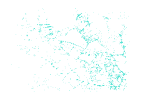

In [30]:
gplot(graph, norm_locs_x, norm_locs_y, arrowlengthfrac=0.0)

In [31]:
calc_cosine_dist(p1, p2) = dot(p1, p2) / (norm(p1) * norm(p2))

calc_euclidean_dist(p1, p2) = norm(p1 - p2)

function encode_edges(G, parent, node, src, dst)
    
    ret = fill(0.0, (max_out_degree, 7))
    
    x_u = norm_locs_x[node]
    y_u = norm_locs_y[node]
    x_dst = norm_locs_x[dst]
    y_dst = norm_locs_y[dst]

    for (idx, out_neighbor) in enumerate(outneighbors(G, node))
        
        out_neighbor == parent && continue
        
        x_v = norm_locs_x[out_neighbor]
        y_v = norm_locs_y[out_neighbor]
        
        ret[idx, 1] = 0.0
        ret[idx, 2] = g_distmx[node, out_neighbor]
        ret[idx, 3] = calc_cosine_dist([x_v-x_u, y_v-y_u], [x_dst-x_u, y_dst-y_u])
        ret[idx, 4] = calc_euclidean_dist([x_v, y_v], [x_dst, y_dst])
        ret[idx, 5] = x_v
        ret[idx, 6] = y_v
        
        ret[idx, end] = out_neighbor
        
    end
    
    return (ret, x_dst, y_dst)
    
end

encode_edges (generic function with 1 method)

In [32]:
function generate_stochastic_dataset(G; sample_size_lower_bound=100, verbose_frequent=10)
    
    pair_path_dict = Dict()
    sample_cnt = 0
    X = []
    y = []
    
    while true
        src = rand(1:num_nodes)
        dst = rand(1:num_nodes)
        
        src == dst && continue
        
        (src, dst) in keys(edge_weights) && continue    
        
        for (src, dst) in [(src, dst), (dst, src)]
    
            path = a_star(graph, src, dst, g_distmx)
            
            length(path) == 0 && break
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = 0
            cur_node = src
            
            for edge in path
                
#                 println("parent:($(parent_node)), X:($(cur_node), $(dst)), y:($(edge.dst))")
                
                
                push!(X, encode_edges(G, parent_node, cur_node, src, dst))
                push!(y, edge.dst)
                
                parent_node = cur_node
                cur_node = edge.dst
                
                sample_cnt += 1
                sample_cnt % verbose_frequent == 0 && println("Collected $(sample_cnt) samples.")
            end
        end
        
        sample_cnt >= sample_size_lower_bound && break
        
    end
    
    return X, y, pair_path_dict, sample_cnt
    
end

generate_stochastic_dataset (generic function with 1 method)

In [94]:
@time begin
features, labels, pair_path_dict, sample_cnt = generate_stochastic_dataset(graph, sample_size_lower_bound=100000, verbose_frequent=20000);
end
@assert length(features) == length(labels) == sample_cnt

Collected 20000 samples.
Collected 40000 samples.
Collected 60000 samples.
Collected 80000 samples.
Collected 100000 samples.
216.033665 seconds (233.76 M allocations: 8.389 GiB, 2.50% gc time)


In [ ]:
pair_path_dict

In [98]:
max_path_len = maximum(map(e -> length(e), values(pair_path_dict)))
println(max_path_len)

132


# Is data augmentation really helpful?
Perhap when overdone, data augmentation only makes it harder to train.
As of this moment, data augmentation will be ignored.

In [99]:
function find_label_idx(feature, label)
    
    num_row = size(feature)[1]
    ret_idx = 1
    
    for row_idx in 1:num_row
        if feature[row_idx, end] == label
            ret_idx = row_idx
        end
    end
    
    ret_idx
end

function augment_dataset(X, y; aug_multiple=20, verbose_frequent=500)
    
    org_sample_size = length(y)
    aug_sample_size = aug_multiple * org_sample_size
    feature_size = max_out_degree * 6 + 2
    
    X_aug, y_aug = zeros(Float32, aug_sample_size, feature_size), zeros(Int, aug_sample_size)
    indices = 1:max_out_degree
    
    cur_sample_idx = 1
    
    for pair in zip(X, y)
        feature = pair[1]
        label = pair[2]
        
        for _ in 1:aug_multiple
             
#             shuffled_indices = shuffle(MersenneTwister(now().instant.periods.value), indices)
            shuffled_indices = indices
            feature_tmp = feature[1][shuffled_indices, :]
            label_tmp = find_label_idx(feature_tmp, label)
            
            feature_tmp = transpose(feature_tmp[:, 1:end-1])

            
            X_aug[cur_sample_idx, :] = push!(vcat(feature_tmp...), feature[2], feature[3])
            y_aug[cur_sample_idx] = label_tmp - 1
            
            cur_sample_idx += 1
            
            if cur_sample_idx % verbose_frequent == 0
                println("Processed $(cur_sample_idx) samples")
            end
        end
    end
    
    return transpose(X_aug), y_aug
end

augment_dataset (generic function with 1 method)

In [ ]:
X, y = augment_dataset(features, labels, aug_multiple=1, verbose_frequent=5000)

println(size(X))
println(size(y))

In [106]:
count(x -> x == 3, y)

216

In [107]:
split_at = [rand() > 0.2 for i in 1:length(y)]

X_train = X[:, split_at]
y_train = y[split_at]

X_val = X[:, .!split_at]
y_val = y[.!split_at];

In [108]:
println(size(X_train))
println(size(y_train))
println(size(X_val))
println(size(y_val))

(26, 80112)
(80112,)
(26, 19893)
(19893,)


In [109]:
function build_model(context)

    mlp = @mx.chain mx.Variable(:data)             =>
      mx.FullyConnected(name=:fc1, num_hidden=1024) =>
      mx.Activation(name=:relu1, act_type=:relu)   =>
      mx.FullyConnected(name=:fc2, num_hidden=512)  =>
      mx.Activation(name=:relu2, act_type=:relu)   =>
      mx.FullyConnected(name=:fc3, num_hidden=max_out_degree)  =>
      mx.SoftmaxOutput(name=:softmax)
    
    return mx.FeedForward(mlp, context=context)
end

build_model (generic function with 1 method)

# First overfit the entire dataset

In [110]:
batch_size = 128

train_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size, shuffle=true)
val_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size);

In [111]:
model = build_model(mx.gpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode softmax, MXNet.mx.Context[GPU0], #undef, #undef, #undef)

In [171]:
mx.fit(model, mx.ADAM(),
    train_provider,
    n_epoch=1,
    eval_data=val_provider,
    verbosity=3)

INFO: Start training on MXNet.mx.Context[GPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 2 MB allocated on GPU0
INFO: Start training...
INFO: == Epoch 001/001 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9875
INFO:               time = 10.3609 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9883
INFO: Finish training on MXNet.mx.Context[GPU0]


In [172]:
using MLBase

pred = mx.predict(model, 
        mx.ArrayDataProvider(X, batch_size=batch_size), verbosity=0)

pred = map(i -> indmax(pred[:, i]), 1:length(y))

confusmat(max_out_degree, y+1, pred)

4×4 Array{Int64,2}:
 72921    795    34    0
   313  22570     9    0
    11     12  3124    0
     0      0     1  215

In [146]:
function nn_infer_next_node(G, parent, cur_node, src, dst, model)

    input_vec, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    real_input_vec = push!(vcat(transpose(input_vec[:, 1:end-1])...), x_dst, y_dst)
    
    pred = mx.predict(model, mx.ArrayDataProvider(reshape(real_input_vec, :, 1)), verbosity=0)
    pred_idx = findmax(pred)[2]
    neighbor = Int(input_vec[pred_idx, end])
    
    if neighbor == 0
        
        avaliable_neighbors = filter(x -> x > 0, input_vec[:, end])
        
        if length(avaliable_neighbors) != 0
            println("Invalid prediction, randomizing next node")
            neighbor = Int(avaliable_neighbors[rand(1:end)])
        else
            # TODO the algorithm can be made smarter
            return -1, 0
        end
    end
    
    return neighbor, edge_weights[(cur_node, neighbor)]
end

function dijkstra_path_finder(G, src, dst, model; invalid_path_len_threshold=200)
    
    path = [src]
    parent_node = 0
    cur_node = src
    total_weights = 0.0
    
    while true
        if length(path) >= invalid_path_len_threshold
            return path, total_weights, false
        end
        
        next_node, weight = nn_infer_next_node(G, parent_node, cur_node, src, dst, model)
        
        if next_node == -1
            
            if !has_edge(G, (cur_node, parent_node))
                return path, total_weights, false
            end
            
            println("No available node to choose, turning back")
            parent_node, cur_node = cur_node, parent_node
            continue
        end
        
        total_weights += weight
        push!(path, next_node)
        
        if next_node == dst
            return path, total_weights, true
        end
        
        parent_node = cur_node
        cur_node = next_node
    end

end

function build_ground_truth_path(src, dst)
    
    edges = pair_path_dict[(src, dst)]
    
    path = [edges[1].src]
    
    for edge in edges
       push!(path, edge.dst) 
    end
    
    path
end

build_ground_truth_path (generic function with 1 method)

In [147]:
function calc_statistics(G, num_to_test)
   
    found_cnt = 0
    opt_path_cnt = 0
    
    pairs = shuffle(collect(keys(pair_path_dict)))[1:num_to_test]
    
    for pair in pairs
        src, dst = pair[1], pair[2]

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model, 
                                invalid_path_len_threshold=max_path_len * 2)
        dijkstra_path = build_ground_truth_path(src, dst)
        
        found == false && continue
        
        found_cnt += 1
        
        if nn_path == dijkstra_path
            opt_path_cnt += 1
        end
    end
    
    return found_cnt, opt_path_cnt
end

calc_statistics (generic function with 1 method)

In [148]:
function print_paths_statistics(G, num_to_test)

    num_total_path = num_to_test

    found_cnt, opt_path_cnt = calc_statistics(G, num_to_test)
    
    @printf "%d out of %d can find path: %f\n" found_cnt num_total_path float(found_cnt)/num_total_path
    @printf "%d out of %d can find optimal path: %f\n" opt_path_cnt found_cnt float(opt_path_cnt)/found_cnt
    @printf "%d out of %d all paths can find optimal paths: %f\n" opt_path_cnt num_total_path float(opt_path_cnt)/num_total_path
    
end

print_paths_statistics (generic function with 1 method)

# N.B.

When the model is able to find the optimal path
with high probability, the model has learned well.

In [ ]:
percentage_found = []
percentage_opt_found = []
percentage_opt_all = []

for _ in 1:10
    num_total_path = 200
    
    found_cnt, opt_path_cnt = calc_statistics(graph, num_total_path)
    push!(percentage_found, found_cnt/num_total_path)
    push!(percentage_opt_found, opt_path_cnt/found_cnt)
    push!(percentage_opt_all, opt_path_cnt/num_total_path)
end

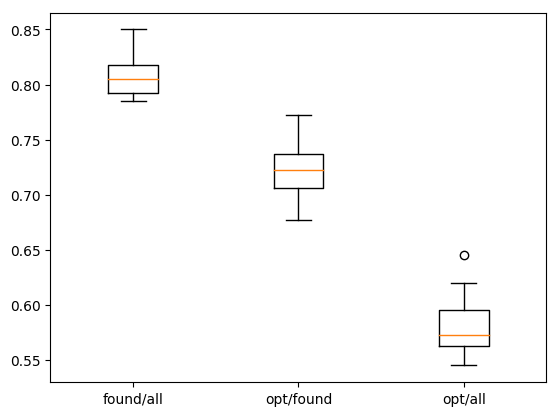

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7…
  "fliers"   => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7…
  "boxes"    => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7…
  "caps"     => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7…
  "medians"  => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7…

In [150]:
using PyPlot

boxplot([percentage_found, percentage_opt_found, percentage_opt_all],
        labels=["found/all", "opt/found", "opt/all"]) # Basic